In [1]:
import os
import urllib
import telebot
import torch
import torchvision.transforms as transforms
import torchvision.io
from PIL import Image
from io import BytesIO
import torch.nn as nn
import base64
import torch.nn.functional as F
import numpy as np
import torchvision
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
from telebot import types

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0_0 = nn.Conv2d(3, 64, 7, stride=2, padding=0)
        
        self.conv1_0 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
        self.norm1_0 = nn.GroupNorm(32, 128)
        
        self.conv2_0 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.norm2_0 = nn.GroupNorm(32, 128)
        self.conv2_1 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        self.norm2_1 = nn.GroupNorm(64, 256)
        
        self.conv3_0 = nn.Conv2d(256, 256, 3, stride=1, padding=0)
        self.norm3_0 = nn.GroupNorm(64, 256)

        
        self.conv4_0 = nn.Conv2d(256, 512, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(512, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(32, 2)
        
        
        
    def forward(self, x):
        

        out = self.conv0_0(x)
        out = self.act(out)
        #out = self.maxpool(out)

        out = self.conv1_0(out)
        out = self.norm1_0(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2_0(out)
        out = self.norm2_0(out)
        out = self.act(out)
        out = self.conv2_1(out)
        out = self.norm2_1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3_0(out)
        out = self.norm3_0(out)
        out = self.act(out)

        out = self.conv4_0(out)
        out = self.act(out)
    

        
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        
        out = self.linear1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.act(out)
        

        return out                    

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

token = '6002633936:AAG3pw2BpHaL_S3tWLv7RjT3CLJH6rQCcxA'
# Загрузка модели
model = Net().to(device)
model.load_state_dict(torch.load('net_85,7.pth'))
#model = torch.hub.load('pytorch/vision', 'vgg16', pretrained=True)
model.eval()

Net(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0_0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1_0): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv2_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2_0): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv2_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm2_1): GroupNorm(64, 256, eps=1e-05, affine=True)
  (conv3_0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm3_0): GroupNorm(64, 256, eps=1e-05, affine=True)
  (conv4_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=32, out_features

In [4]:
# Функция для классификации изображения
def classify_image(image, my_img):
    
    # Преобразование изображения в тензор PyTorch и нормализация
    transform = transforms.Compose(
    [transforms.Resize((112, 112)),    # Изменяем размер изображения до 224x224
     transforms.ToTensor(),    # Преобразуем изображение в тензор
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    image = transform(image).to(device)
    image = image.unsqueeze_(0)

    # Классификация изображения с помощью модели
    with torch.no_grad():
        output = model(image)
    
    predicted_class = torch.argmax(output).item()

    probs = F.softmax(output, dim=1)

    dog_prob = probs[0][0].item()  # вероятность класса кошки
    cat_prob = probs[0][1].item()  # вероятность класса собаки

    if predicted_class == 0: 
        print('      КОШКА %.2f%%' % (cat_prob*100))
        my_img.save("cat_" + (str(cat_prob*100)) + ".jpg")
        return 'Я почти уверен, что это котик!'
    else: 
        print('      СОБАКА %.2f%%' % (dog_prob*100))
        my_img.save("dog_" + (str(dog_prob*100)) + ".jpg")
        return 'Я почти уверен, что это пёсик!'

In [5]:
def image_console(img):
    
    transform = transforms.Resize((112, 112))
    img = transform(img)
    
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.show()

In [6]:
# Создание бота
bot = telebot.TeleBot(token)

In [7]:
# Обработчик команды /start
@bot.message_handler(commands=['start'])
def send_welcome(message):
    bot.reply_to(message, "Привет! Я бот, который может отличать собак от кошек. Пришли мне фото своего питомца и я скажу, кто на нем изображен.\n\nУчти, что бот реагирует только на изображения.\n\nСамые смешные реакции бота (не только на животных) кидай мне в личку :)")

In [8]:
# Обработчик изображения
@bot.message_handler(content_types=['photo'])
def handle_photo(message):

    # Загрузка изображения из сообщения
    file_info = bot.get_file(message.photo[-1].file_id)
    
    image_url = 'https://api.telegram.org/file/bot{0}/{1}'.format(token, file_info.file_path)
    
    with urllib.request.urlopen(image_url) as url:
        image_file = BytesIO(url.read())
    
    image = Image.open(image_file)
    
    my_img = image
    image_console(my_img)
    
    # Классификация изображения и отправка результата
    result = classify_image(image, my_img)

#     markup = types.ReplyKeyboardMarkup(one_time_keyboard = True)
#     button1 = types.KeyboardButton("Да, ты прав, это кошка")
#     markup.add(button1)
#     button2 = types.KeyboardButton("-------Кнопка 2-------")
#     markup.add(button2)
#     button3= types.KeyboardButton("-------Кнопка 3-------")
#     markup.add(button3)
    
#     bot.send_message(message.chat.id, result, reply_markup=markup)
    bot.send_message(message.chat.id, result)

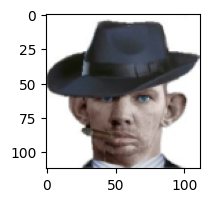

      СОБАКА 4.09%


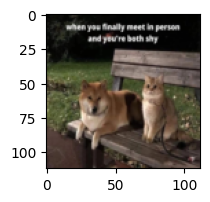

      СОБАКА 26.28%


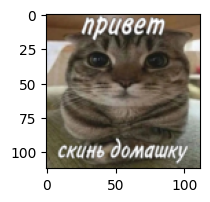

      КОШКА 0.11%


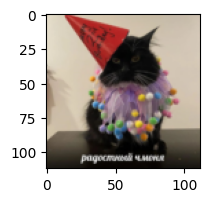

      СОБАКА 16.50%


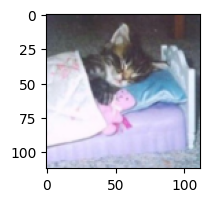

      КОШКА 18.53%


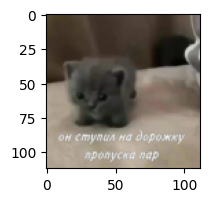

      КОШКА 0.53%


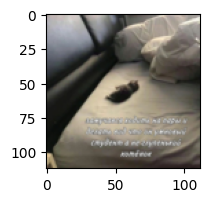

      СОБАКА 11.66%


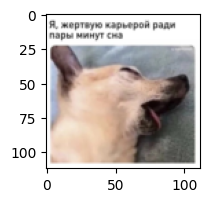

      КОШКА 0.40%


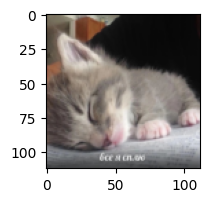

      КОШКА 1.33%


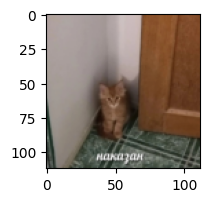

      КОШКА 0.09%


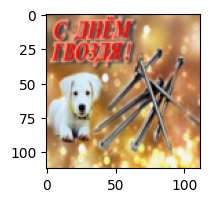

      СОБАКА 0.53%


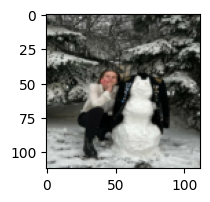

      СОБАКА 19.22%


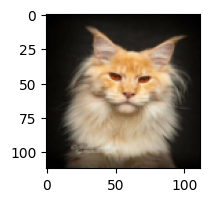

      КОШКА 0.02%


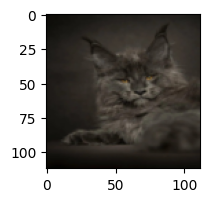

      КОШКА 0.01%


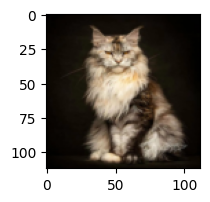

      КОШКА 0.00%


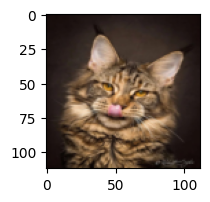

      КОШКА 0.00%


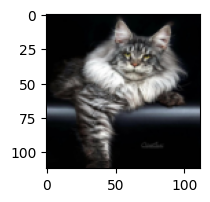

      КОШКА 0.02%


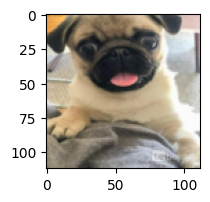

      СОБАКА 0.00%


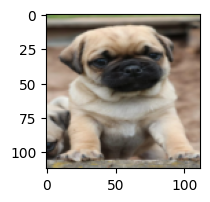

      СОБАКА 4.05%


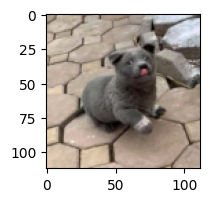

      СОБАКА 25.13%


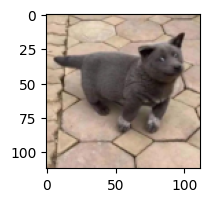

      СОБАКА 8.72%


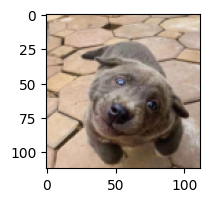

      СОБАКА 0.17%


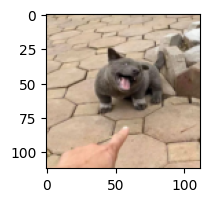

      КОШКА 25.31%


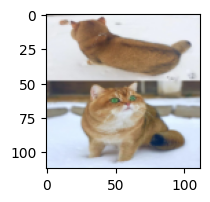

      КОШКА 38.49%


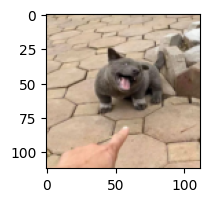

      КОШКА 25.31%


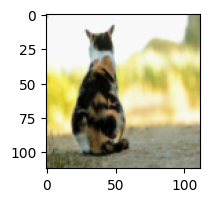

      КОШКА 25.05%


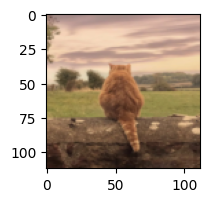

      СОБАКА 7.72%


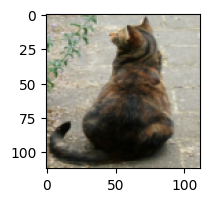

      КОШКА 5.19%


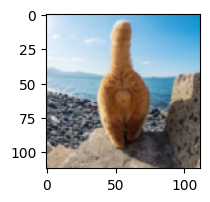

      СОБАКА 31.86%


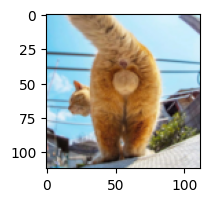

      СОБАКА 1.08%


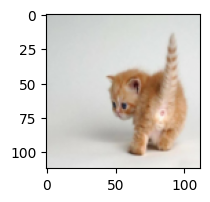

      СОБАКА 0.09%


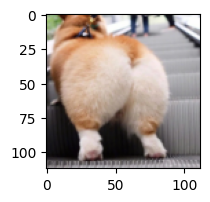

      КОШКА 9.90%


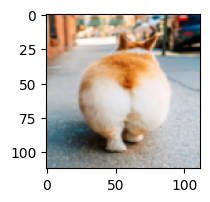

      СОБАКА 30.14%


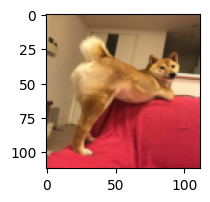

      СОБАКА 33.45%


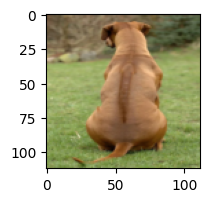

      СОБАКА 1.36%


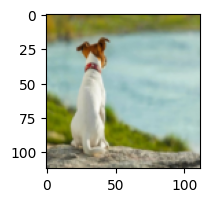

      КОШКА 30.44%


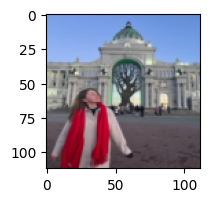

      КОШКА 38.57%


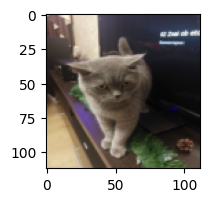

      КОШКА 0.26%


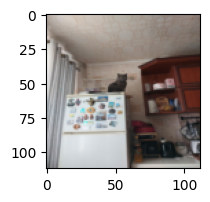

      КОШКА 49.56%


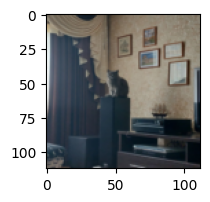

      КОШКА 8.00%


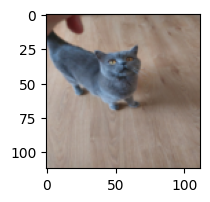

      КОШКА 1.60%


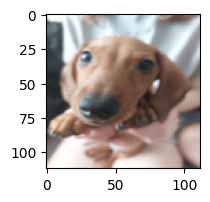

      КОШКА 9.35%


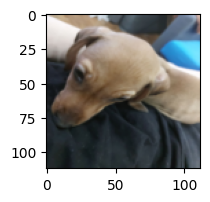

      СОБАКА 29.28%


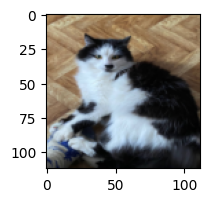

      КОШКА 0.14%


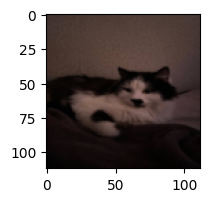

      КОШКА 0.36%


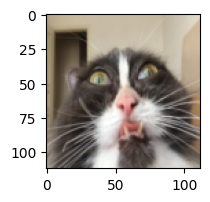

      КОШКА 14.18%


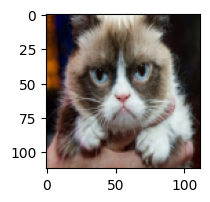

      КОШКА 0.07%


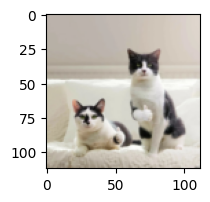

      КОШКА 6.59%


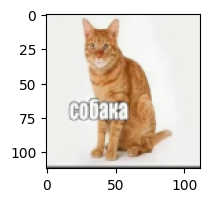

      КОШКА 2.03%


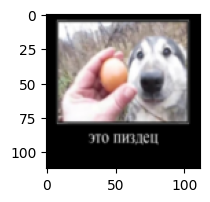

      КОШКА 29.45%


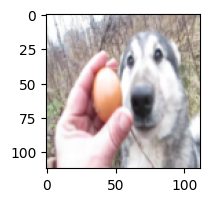

      СОБАКА 46.51%


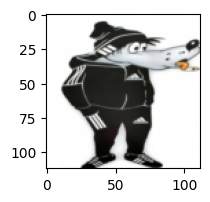

      СОБАКА 19.78%


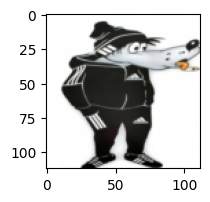

      СОБАКА 19.78%


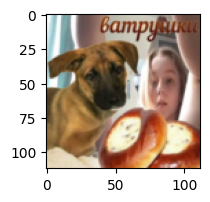

      СОБАКА 8.80%


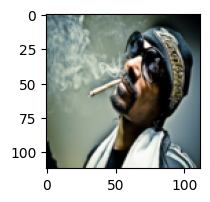

      СОБАКА 0.05%


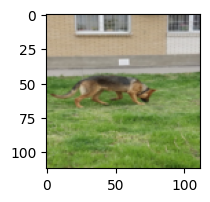

      СОБАКА 44.51%


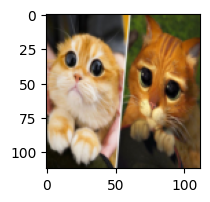

      СОБАКА 4.19%


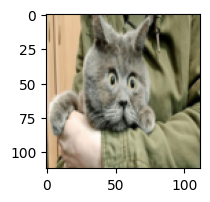

      КОШКА 0.03%


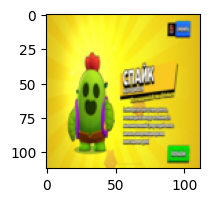

      СОБАКА 28.58%


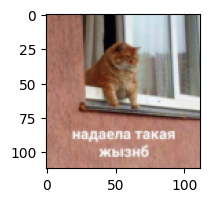

      СОБАКА 27.09%


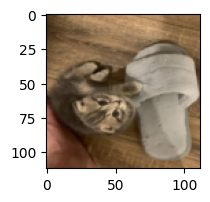

      СОБАКА 49.42%


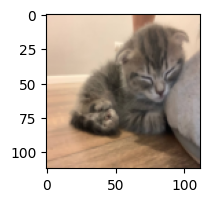

      КОШКА 0.10%


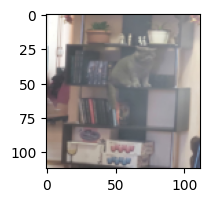

      КОШКА 28.46%


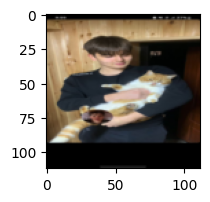

      СОБАКА 36.29%


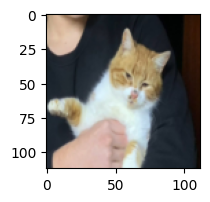

      КОШКА 0.00%


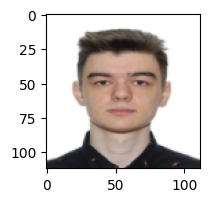

      СОБАКА 1.62%


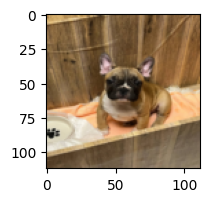

      КОШКА 34.30%


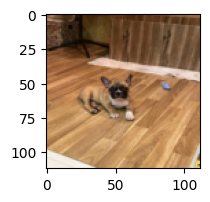

      СОБАКА 0.26%


In [ ]:
# Запуск бота
bot.polling()